# Import library

In [1]:
from big_slam import load_test_data,recurrence_plot,wave_slam_detector,lead_lag_detector,max_peak_detector
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler

#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.size'] = 12
#plt.rcParams['font.family'] = "serif"

## Load stationary manoeuvre data

In [2]:
df_original = pd.read_pickle('SAAII_Data/Stationary/0.pkl')

#Accelerometers used
z_col =['CL01_S_Z',
        'CH03_P_Z_Back',
        'CH04_P_Z_Front',
        'CH05_S_Z_Back',
        'CH06_S_Z_Front',
        'ES01_S_Z',
        'FW01_P_Z',
        'ST01_S_Z',
        'ST02_P_Z',
        'SG01_S_Z',
        'SG03_P_Z']

df = df_original[z_col]
df.head()

,CL01_S_Z,CH03_P_Z_Back,CH04_P_Z_Front,CH05_S_Z_Back,CH06_S_Z_Front,ES01_S_Z,FW01_P_Z,ST01_S_Z,ST02_P_Z,SG01_S_Z,SG03_P_Z
0,-0.425487,-0.000879,0.043888,0.054375,-0.016171,-0.111854,-0.047407,0.111614,-0.247290,0.302655,0.427493
1,-0.449258,-0.014415,0.057723,0.047073,0.010733,-0.073513,-0.127475,-0.109071,0.136783,0.327998,0.440835
2,-0.439750,-0.005822,0.063567,0.036749,0.011610,-0.089572,-0.076402,-0.231765,0.014536,0.286435,0.312320
3,-0.398219,-0.004088,0.058758,0.037972,-0.021239,-0.053497,-0.076894,-0.227648,-0.141521,0.351431,0.350123
4,-0.368745,-0.017808,0.014703,0.037756,-0.021011,-0.078123,-0.071223,-0.017144,-0.167576,0.297561,0.340960


# Pre-processing
## Filter to desired frequency band

### Figure 5.1 - Frequency band examples

In [3]:
#Filter the signal 1-20 Hertz
lp_1 = signal.butter(10, 1, btype='lp', fs=2048, output='sos')

bp_1_5 = signal.butter(10, (1,5), btype='bandpass', fs=2048, output='sos')

bp_5_10 = signal.butter(10, (5,9), btype='bandpass', fs=2048, output='sos')

bp_10_15 = signal.butter(10, (9,15), btype='bandpass', fs=2048, output='sos')


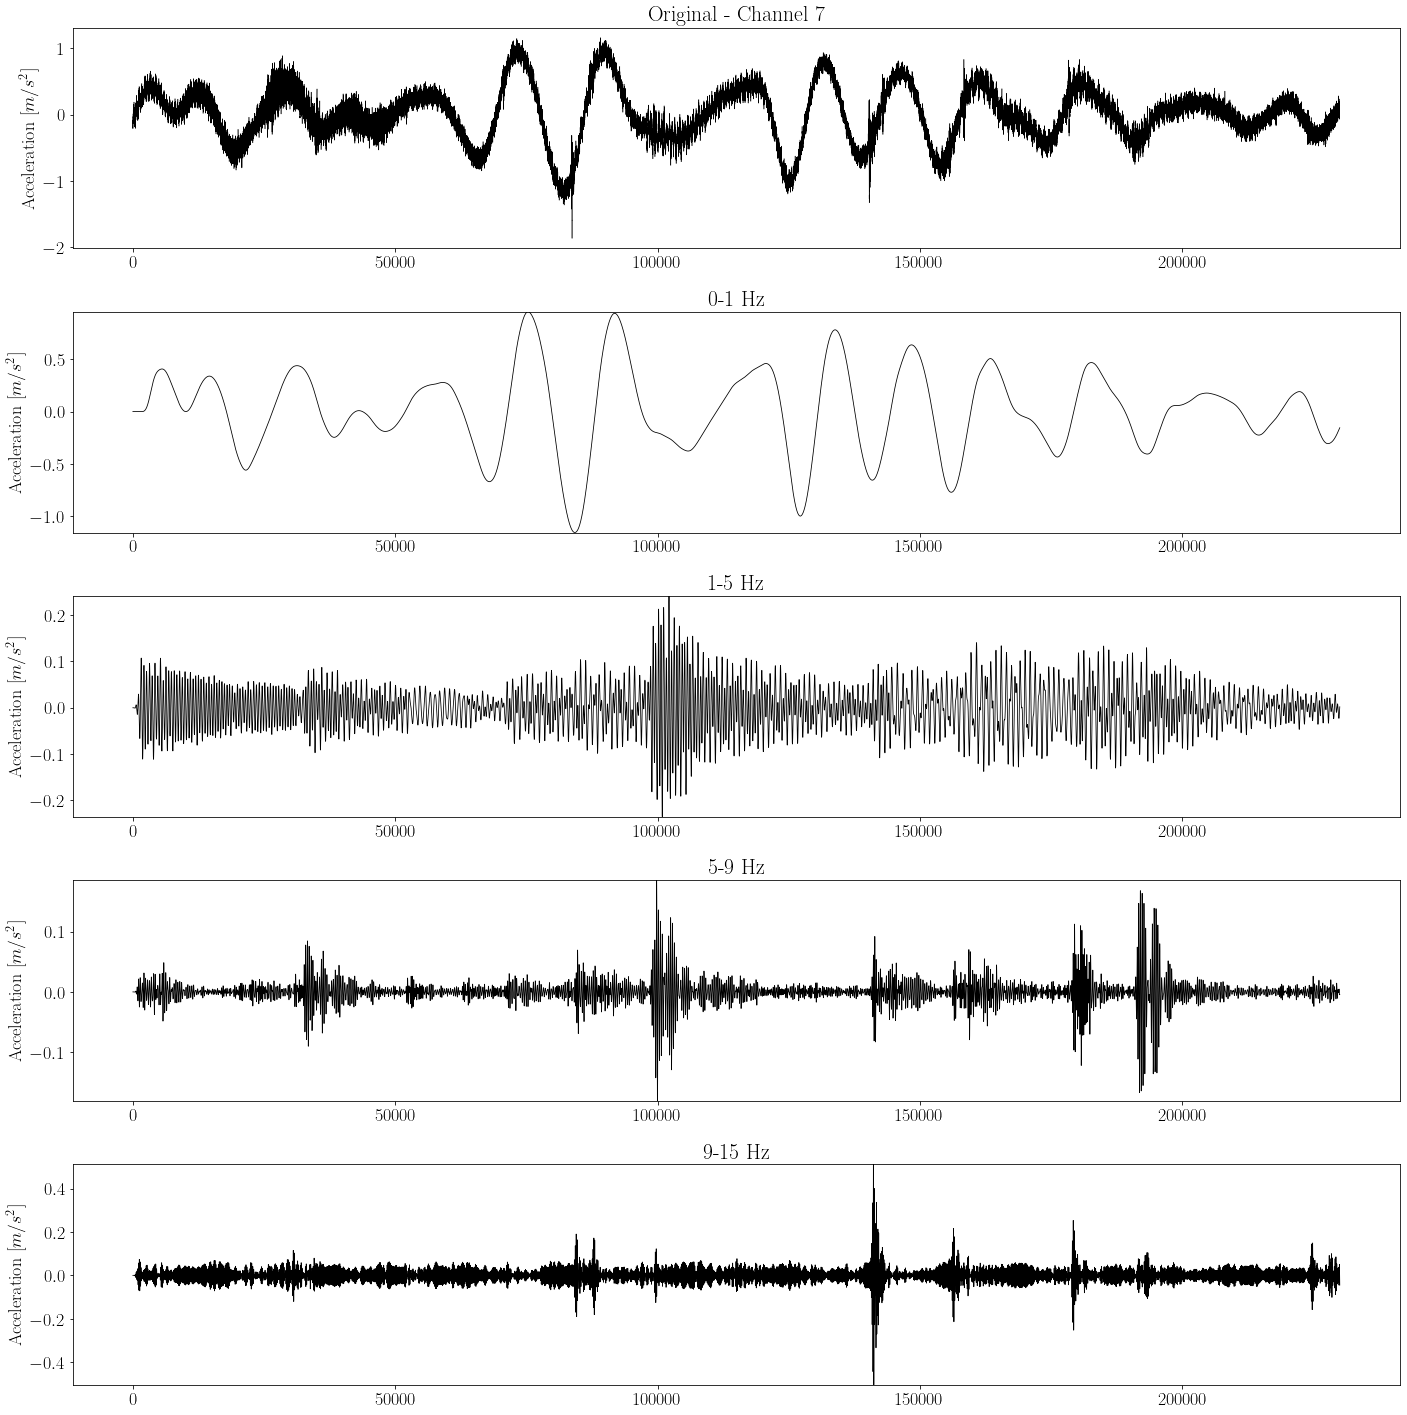

In [4]:
#Set plot parameters
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
plt.rcParams['font.family'] = "serif"

filters = [lp_1,bp_1_5,bp_5_10,bp_10_15]
filter_names = ['Original - Channel 7','0-1 Hz','1-5 Hz','5-9 Hz','9-15 Hz']

fig,ax = plt.subplots(5,1,figsize=(20,20))

x = df.iloc[150000:380000,10].values

ax[0].plot(x,'k',linewidth=0.5)
ax[0].set_title(filter_names[0])
ax[0].set_ylabel(r'Acceleration [$m/s^2$]')

for i,f in enumerate(filters):
    
    s = signal.sosfilt(f, x)
    ax[i+1].plot(s,'k',linewidth=0.8)
    ax[i+1].set_title(filter_names[i+1])
    ax[i+1].set_ylim(min(s),max(s))
    ax[i+1].set_ylabel(r'Acceleration [$m/s^2$]')
    
plt.tight_layout()
#plt.savefig('SAAII_frequency_bands.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

In [5]:
#Filter the signal 5-9 Hertz
sos = signal.butter(3, (5,9), btype='bandpass', fs=2048, output='sos')
df_filtered = df.copy()

for col in df.columns[:]:
    df_filtered[col] = signal.sosfilt(sos, df[col].values)

## Normalization

In [6]:
#Robust scale the data
scaler = RobustScaler()
df_Scaled = df_filtered.copy()
df_Scaled.iloc[:,:] = scaler.fit_transform(df_filtered)

In [7]:
df_Scaled.describe()

,CL01_S_Z,CH03_P_Z_Back,CH04_P_Z_Front,CH05_S_Z_Back,CH06_S_Z_Front,ES01_S_Z,FW01_P_Z,ST01_S_Z,ST02_P_Z,SG01_S_Z,SG03_P_Z
count,1.843200e+06,1.843200e+06,1.843200e+06,1.843200e+06,1.843200e+06,1.843200e+06,1.843200e+06,1.843200e+06,1.843200e+06,1.843200e+06,1.843200e+06
mean,2.261191e-03,3.417830e-04,-2.938089e-03,4.677919e-03,7.465276e-04,-1.524203e-03,-1.823294e-03,3.547928e-03,1.525717e-03,1.347744e-03,1.081040e-03
std,2.049160e+00,1.514127e+00,1.892843e+00,1.936021e+00,1.897411e+00,1.954392e+00,1.753294e+00,2.269913e+00,2.672402e+00,2.050706e+00,2.198053e+00
min,-7.309129e+01,-3.151798e+01,-7.180214e+01,-6.781991e+01,-5.219313e+01,-8.233872e+01,-3.817548e+01,-8.002747e+01,-1.007699e+02,-8.290438e+01,-9.634140e+01
25%,-4.960575e-01,-4.975389e-01,-5.027091e-01,-4.974286e-01,-4.976911e-01,-5.004583e-01,-5.027539e-01,-4.993727e-01,-4.962646e-01,-4.993429e-01,-5.007561e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.039425e-01,5.024611e-01,4.972909e-01,5.025714e-01,5.023089e-01,4.995417e-01,4.972461e-01,5.006273e-01,5.037354e-01,5.006571e-01,4.992439e-01
max,6.725366e+01,3.498178e+01,7.519980e+01,6.920175e+01,5.436180e+01,8.319604e+01,4.066923e+01,9.027025e+01,1.121269e+02,8.492446e+01,9.054212e+01


## Subsample

In [8]:
#Create sub_sampled index
sub_sampled_index = np.arange(0,df_filtered.shape[0],32)
df_filtered_subsampled = df_Scaled.iloc[sub_sampled_index,:]

df_unfiltered_subsampled = df.iloc[sub_sampled_index,:]

In [9]:
df_filtered_subsampled

,CL01_S_Z,CH03_P_Z_Back,CH04_P_Z_Front,CH05_S_Z_Back,CH06_S_Z_Front,ES01_S_Z,FW01_P_Z,ST01_S_Z,ST02_P_Z,SG01_S_Z,SG03_P_Z
0,0.002152,0.000419,-0.002861,0.004748,0.000796,-0.001535,-0.001882,0.003634,0.001543,0.001420,0.001102
32,-0.369848,-0.005430,-0.012107,0.118140,-0.036863,-0.212037,-0.140796,-0.246276,-0.245475,0.205161,0.251957
64,-1.972249,0.143412,-0.094552,0.609236,-0.076542,-1.132434,-0.726685,-1.330802,-1.435141,1.176190,1.339766
96,-3.521899,0.243057,-0.161788,1.023904,0.042304,-1.897218,-1.541901,-2.539678,-2.883600,2.177405,2.410571
128,-2.718795,0.145832,-0.085293,0.705414,0.285649,-1.118769,-1.288560,-2.369255,-2.762390,1.645847,1.860310
...,...,...,...,...,...,...,...,...,...,...,...
1843040,2.566102,-2.446848,-2.327372,-1.505255,-0.502862,-0.776414,1.635033,-1.981855,-1.263207,0.018987,-0.263528
1843072,3.321434,-2.564530,-2.877593,-1.548848,-0.573479,-0.624224,1.463040,-2.085924,-1.021129,-0.920239,0.116928
1843104,2.980630,-1.988090,-2.567703,-1.215126,-0.875610,-0.175939,1.124751,-1.675206,-0.513038,-1.888621,0.191403
1843136,1.855600,-0.985001,-1.424488,-0.569047,-1.116413,0.070544,0.718782,-0.989940,-0.099392,-2.016100,0.078300


## Plot filtered subsampled data

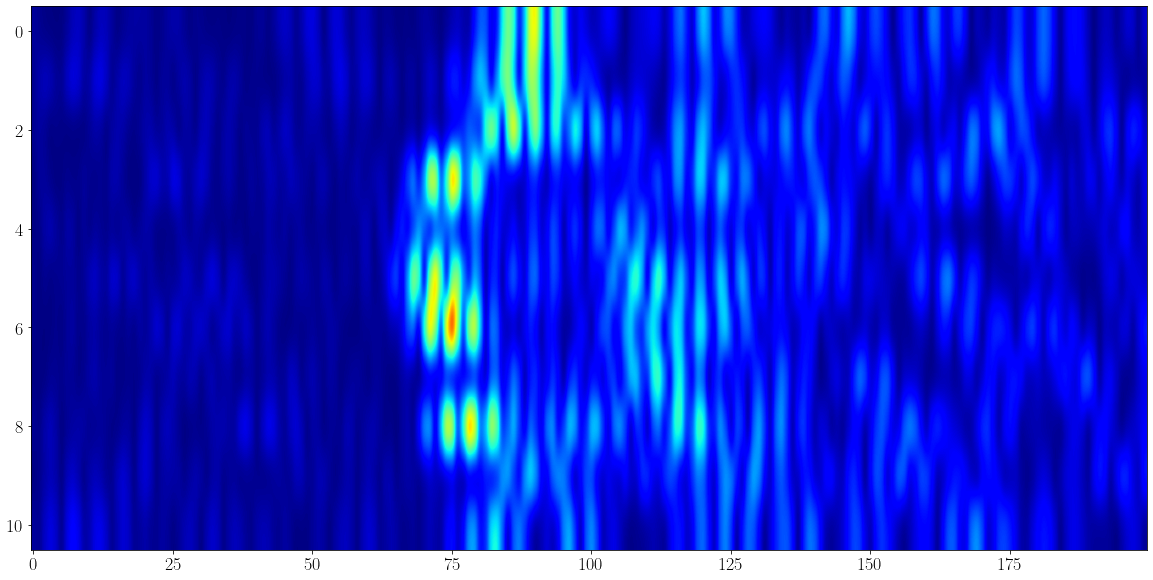

In [174]:
from skimage.transform import resize
fig,ax = plt.subplots(figsize=(20,10))
img_d = df_filtered_subsampled.iloc[10200:10400,[0,2,3,7,9,10,8,6,5,4,1]].abs()

#img_d = resize(img_d.abs().values,(50,50),anti_aliasing=True)

plt.imshow(img_d.T
           ,aspect='auto',interpolation = 'gaussian',cmap='jet')


# Feature extraction
### Using Recurrence plots and pretrained VGG16 CNN

In [147]:
%%time
#Parameters
window_size = 200
stride = 100
compressed_window_size = 100
recurrence_plot_type_1 = 'euclidean'
recurrence_plot_type_2 = 'none'

#create class
wave_slam_class_euc = wave_slam_detector(df_filtered_subsampled.iloc[:,[0,2,3,7,9,10,8,6,5,4,1]])
wave_slam_class_maha = wave_slam_detector(df_filtered_subsampled.iloc[:,[0,2,3,7,9,10,8,6,5,4,1]])

wave_slam_class_euc.feature_extraction(window_size,stride,compressed_window_size,recurrence_plot_type_1)
wave_slam_class_maha.feature_extraction(window_size,stride,compressed_window_size,recurrence_plot_type_2)


CPU times: user 5min 38s, sys: 9.1 s, total: 5min 48s
Wall time: 2min 44s


## Frequency vectors

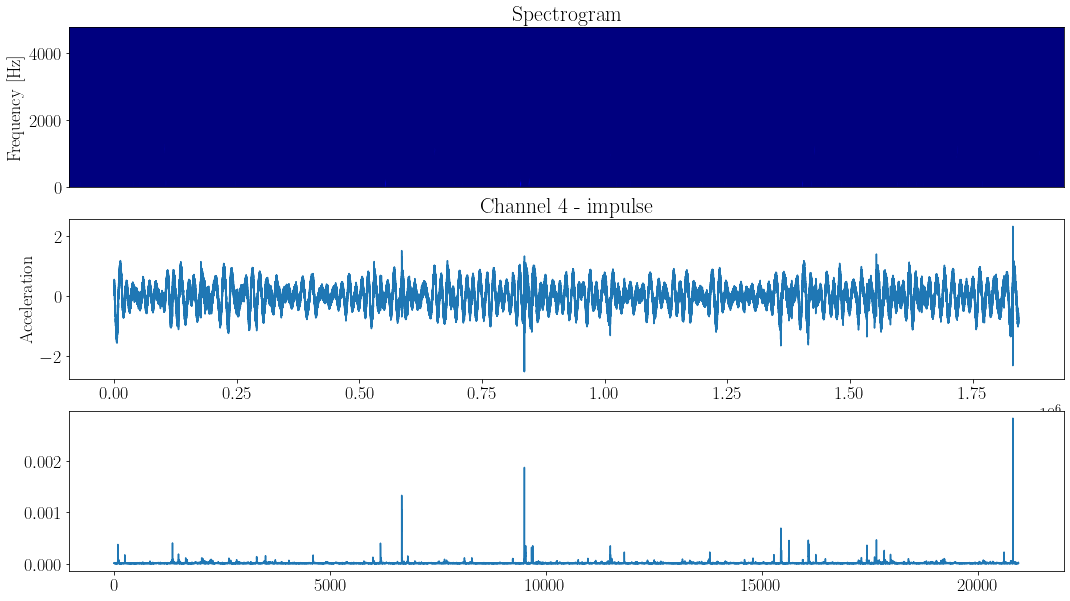

In [166]:
from scipy import signal
from matplotlib import gridspec

x = df.iloc[:,9].values 
freqs, times, spectrogram = signal.spectrogram(x,fs=9500,nfft=9500,nperseg=100,window=('hamming'))


fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(3, 2, height_ratios=(20, 20,20), width_ratios=(50, 1))
# first graph
axes = plt.subplot(gs[0,0])

im = axes.imshow((spectrogram[0:]), aspect='auto', cmap='jet', origin='lower')
axes.set_title('Spectrogram')
axes.set_ylabel(r'Frequency [Hz]')
axes.xaxis.set_visible(False)

# Second graph
axes = plt.subplot(gs[1,0])
axes.plot(x)
#axes.set_xlim(0,10000)
axes.set_title('Channel 4 - impulse')
axes.set_ylabel(r'Acceleration ')

# Second graph
axes = plt.subplot(gs[2,0])
axes.plot(spectrogram[0:70].mean(axis=0))
#axes.set_ylim(0,5e-5)

In [167]:
from sklearn.decomposition import PCA
import umap

pca1 = PCA(n_components=5)
pca1_t = pca1.fit_transform(spectrogram.T)


In [168]:
np.cumsum(pca1.explained_variance_ratio_)

array([0.89841678, 0.95872665, 0.98300304, 0.99008589, 0.99386778])

In [169]:
umap1= umap.UMAP(n_neighbors=5,min_dist=0)

umap1_s = umap1.fit_transform(pca1_t)

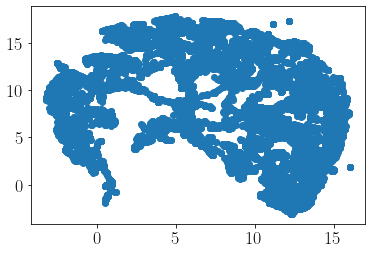

In [170]:
plt.scatter(umap1_s[:,0],umap1_s[:,1])

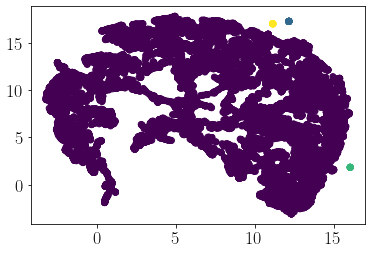

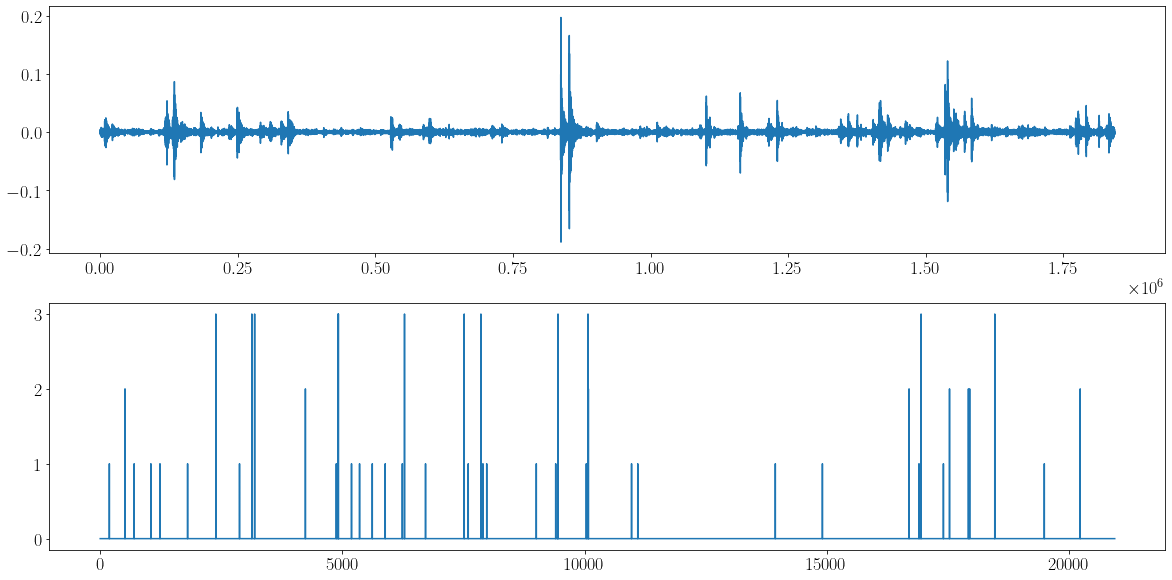

In [172]:
from sklearn.cluster import DBSCAN

cluster_model = DBSCAN(eps=0.5,min_samples=5)
ds = cluster_model.fit(umap1_s)

plt.scatter(umap1_s[:,0],umap1_s[:,1],c=ds.labels_)

fig,ax = plt.subplots(2,1,figsize=(20,10))
ax[0].plot(df_filtered.iloc[:,4])
ax[1].plot(ds.labels_)


## Dimensionality reduction
### PCA : number of components = 30
### Figure 5.2

CPU times: user 840 ms, sys: 85.1 ms, total: 925 ms
Wall time: 370 ms


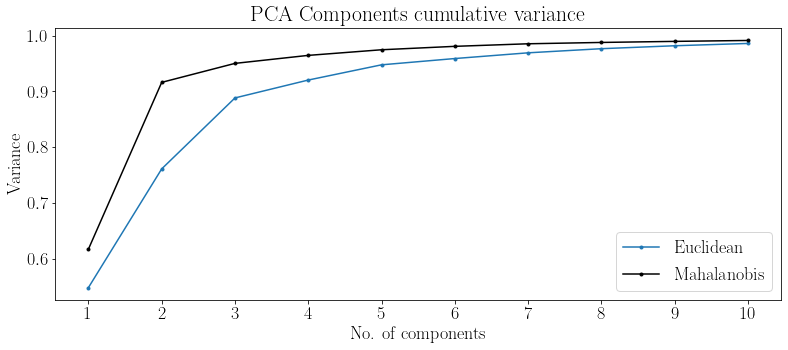

In [148]:
%%time

wave_slam_class_euc.PCA(max_components = 10)
wave_slam_class_maha.PCA(max_components = 10)

#PCA transformation per image type
pca_euc = wave_slam_class_euc.pca_model
pca_maha = wave_slam_class_maha.pca_model


fig,ax = plt.subplots(figsize=(13,5))
plt.plot(np.cumsum(pca_euc.explained_variance_ratio_),marker='.',label = 'Euclidean')
plt.plot(np.cumsum(pca_maha.explained_variance_ratio_),marker='.',label = 'Mahalanobis',c='k')
plt.xticks(range(10))
ax.set_xticklabels(np.arange(10)+1)
plt.title('PCA Components cumulative variance');
plt.xlabel('No. of components');
plt.ylabel('Variance');
plt.legend()

#plt.savefig('PCA_wave_slam_euc_maha.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## UMAP - Uniform manifold approximation and projection
## Figure 5.3

CPU times: user 4.72 s, sys: 116 ms, total: 4.83 s
Wall time: 5.09 s


Text(0.5, 1.0, 'UMAP - Mahalanobis')

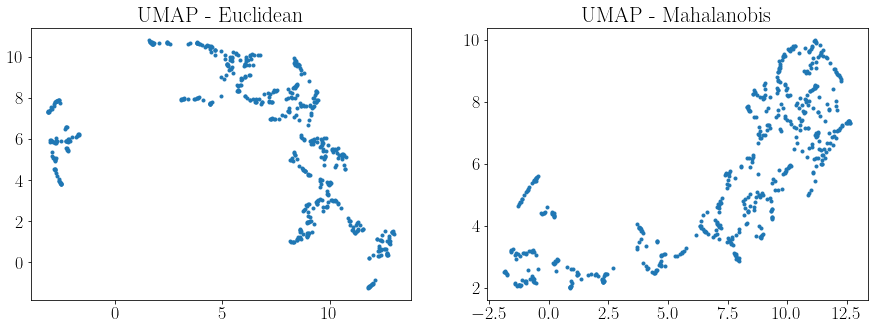

In [159]:
%%time
wave_slam_class_euc.UMAP(n_neighbors=7,min_dist=0,plot=False)
wave_slam_class_maha.UMAP(n_neighbors=7,min_dist=0,plot=False)


umap_trans_euc = wave_slam_class_euc.umap_transformed
umap_trans_maha = wave_slam_class_maha.umap_transformed


fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].scatter(umap_trans_euc[:,0],umap_trans_euc[:,1],marker='.')
ax[0].set_title('UMAP - Euclidean');
ax[1].scatter(umap_trans_maha[:,0],umap_trans_maha[:,1],marker='.')
ax[1].set_title('UMAP - Mahalanobis');

#plt.savefig('UMAP_SAAII.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

# Clustering
## Figure 5.4

Text(0.5, 1.0, 'UMAP decomposition - Euclidean')

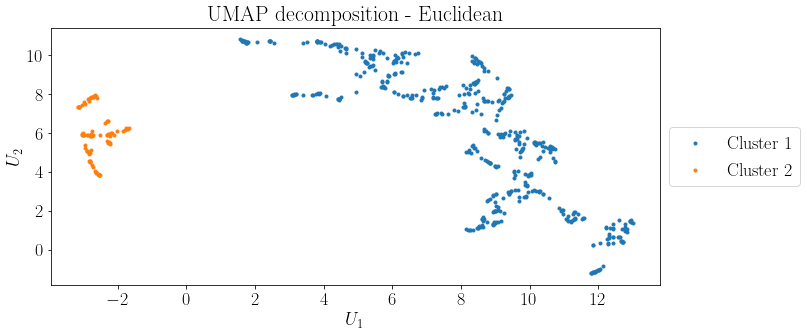

In [160]:

wave_slam_class_euc.clustering(eps=1.5,min_samples=10,plot=True)
plt.title('UMAP decomposition - Euclidean')

#plt.savefig('UMAP_cluster_labels_euclidean_SAAII.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

Text(0.5, 1.0, 'UMAP decomposition - Mahalanobis')

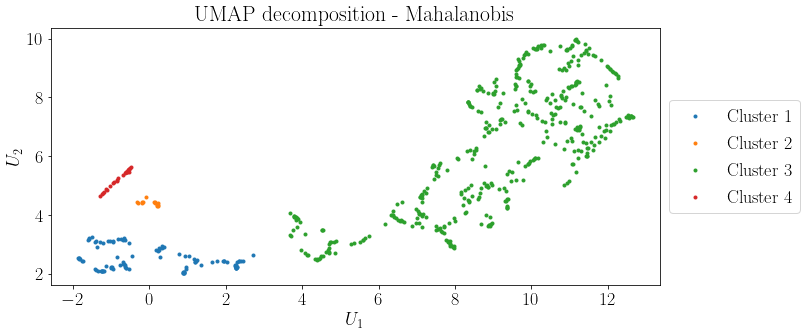

In [161]:
wave_slam_class_maha.clustering(eps=0.7,min_samples=5,plot=True)
plt.title('UMAP decomposition - Mahalanobis')
#plt.savefig('UMAP_cluster_labels_mahalanobis_SAAII.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

## Map cluster labels to time domain

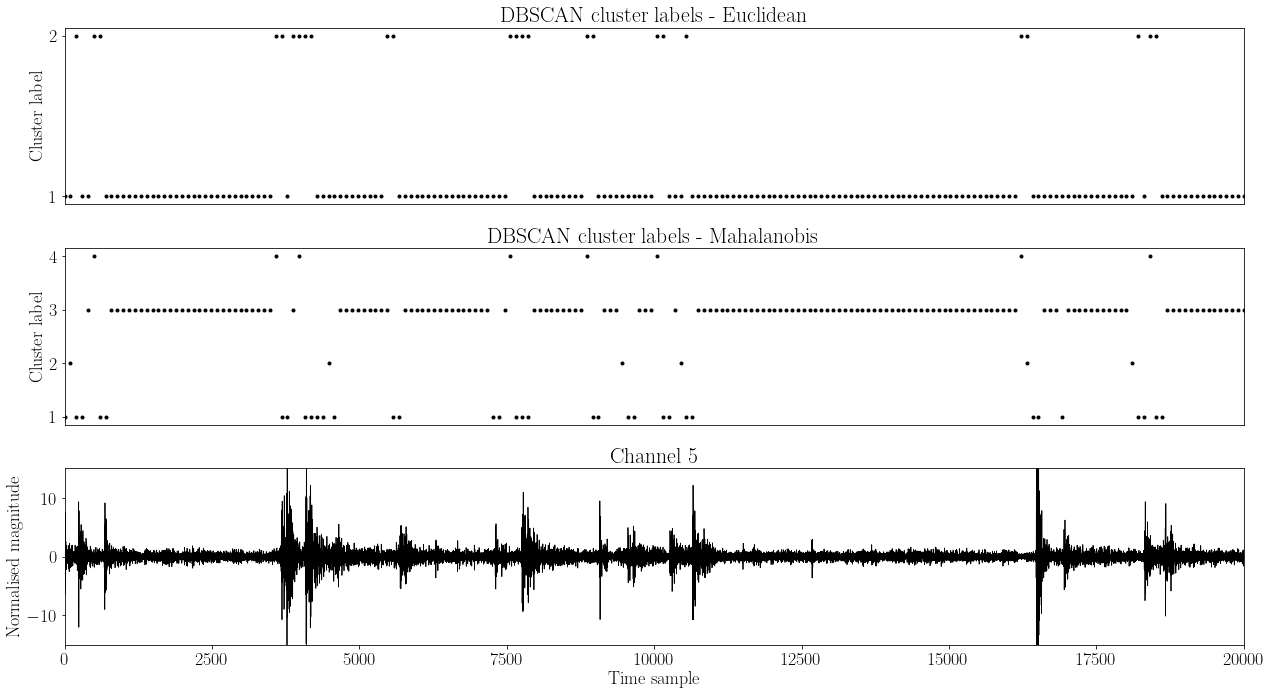

In [162]:
fig,ax = plt.subplots(3,1,figsize=(18,10))

ax[0].plot(wave_slam_class_euc.DBSCAN_feature_labels,'k.')
ax[0].set_ylabel('Cluster label')
ax[0].set_yticks(np.arange(1,wave_slam_class_euc.DBSCAN_feature_labels.max()+1))
ax[0].xaxis.set_visible(False)
ax[0].set_title('DBSCAN cluster labels - Euclidean');
ax[0].set_xlim(0,20000/stride + 1)

ax[1].plot(wave_slam_class_maha.DBSCAN_feature_labels,'k.')
ax[1].set_ylabel('Cluster label')
ax[1].set_yticks(np.arange(1,wave_slam_class_maha.DBSCAN_feature_labels.max()+1))
ax[1].xaxis.set_visible(False)
ax[1].set_title('DBSCAN cluster labels - Mahalanobis');
ax[1].set_xlim(0,20000/stride + 1)
#ax[1].set_ylim(1,stride)


ax[2].plot(df_filtered_subsampled.iloc[:,9].values,'k',linewidth=0.8)
ax[2].set_title('Channel 5');
ax[2].set_ylabel('Normalised magnitude')
ax[2].set_xlabel(r'Time sample');
ax[2].set_xlim(0,20000)
ax[2].set_ylim(-15,15)

plt.tight_layout()

#plt.savefig('Cluster_labels_in_time_SAAII.png', dpi = 300, bbox_inches = 'tight', pad_inches = .1)

# Classification
## Identify cluster corresponding to wave slamming

In [163]:
wave_slam_class_euc.chosen_cluster = 2
wave_slam_class_maha.chosen_cluster = 1

## Impact number and the approximate time of impact is given as:

In [175]:
# cluster in time using eps of 2 sample points
wave_slam_class_euc.clustering_in_time(eps=1);

wave_slam_class_maha.clustering_in_time(eps=1);

/Users/torick/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/Users/torick/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<AxesSubplot:>

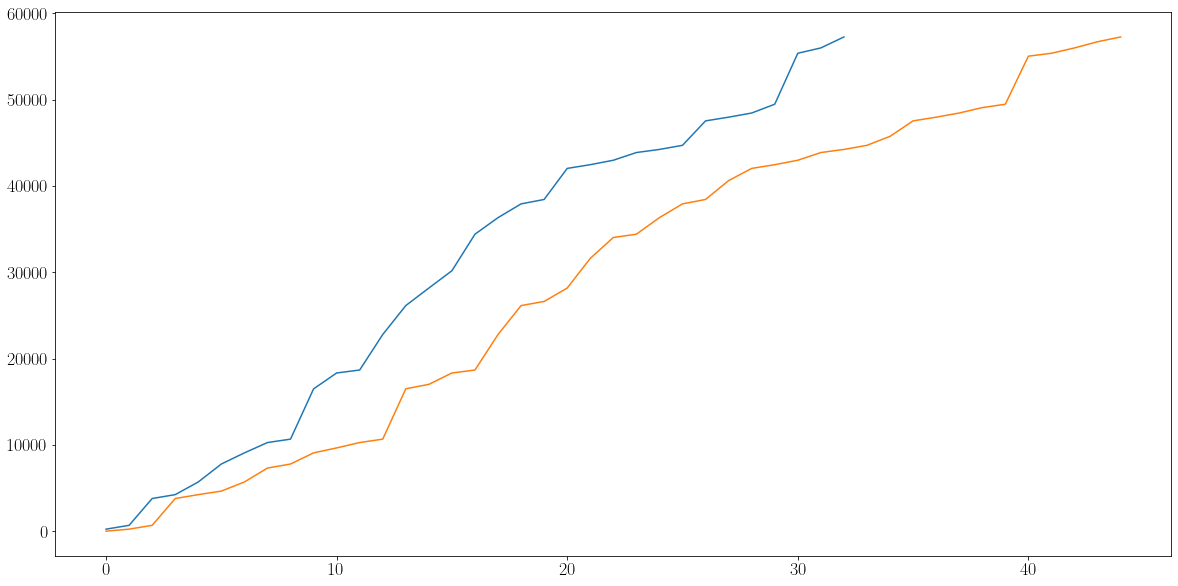

In [176]:
fig,ax = plt.subplots(figsize=(20,10))
#ax.vlines(wave_slam_class_euc.results_df['approximate_impact_time_sample'].values,0,1,color='r',linestyle='dashed',linewidth=5)
#ax.vlines(wave_slam_class_maha.results_df['approximate_impact_time_sample'].values,0,1,color='k',linewidth=5,alpha=0.5)
wave_slam_class_euc.results_df['approximate_impact_time_sample'].plot(ax=ax)
wave_slam_class_maha.results_df['approximate_impact_time_sample'].plot(ax=ax)


## Evaluate results

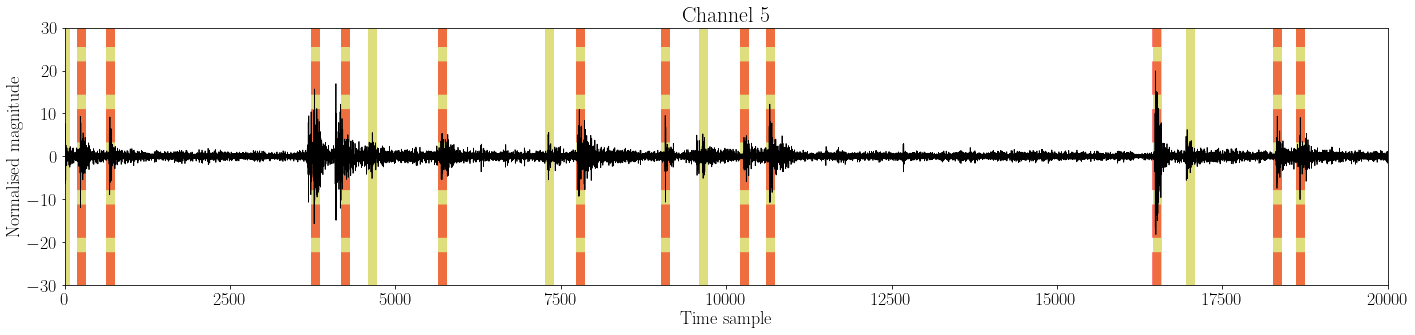

In [201]:
fig,ax = plt.subplots(figsize=(20,5))

ax.vlines(wave_slam_class_maha.results_df['approximate_impact_time_sample'].values,-30,30,linestyle='solid',linewidth=9,color='y',alpha=0.5)
ax.vlines(wave_slam_class_euc.results_df['approximate_impact_time_sample'].values,-30,30,linestyle='dashed',linewidth=9,color='r',alpha=0.5)
ax.plot(df_filtered_subsampled.iloc[:,9].values,'k',linewidth=0.8)
ax.set_title('Channel 5');
ax.set_ylabel('Normalised magnitude');
ax.set_xlabel(r'Time sample');
ax.set_xlim(0,20000)
ax.set_ylim(-30,30)

plt.tight_layout()


## Associated RPs

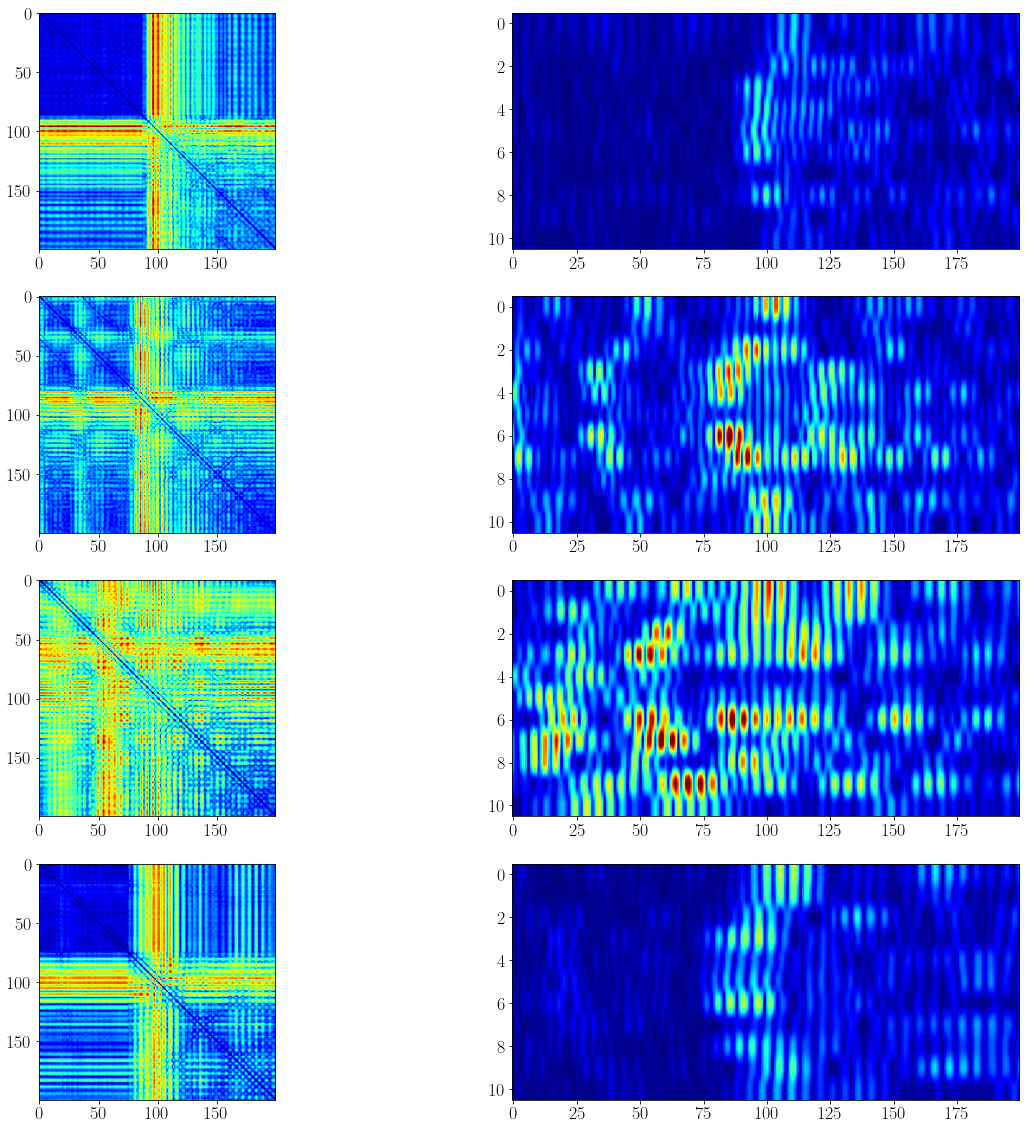

In [178]:
w_times = wave_slam_class_euc.results_df['approximate_impact_time_sample'].values
fig,ax = plt.subplots(len(w_times[1:5]),2,figsize=(20,20))
for i_index,i in enumerate(w_times[1:5]):
    img_data = df_filtered_subsampled.iloc[i-100:i+100,[0,2,3,7,9,10,8,6,5,4,1]].abs()
    img = recurrence_plot(img_data,'euclidean')
    ax[i_index,0].imshow(img,aspect='equal',cmap='jet')#,vmin=0,vmax=1)
    ax[i_index,1].imshow(img_data.T,aspect='auto',cmap='jet',vmin=0,vmax=20)

## Export results

In [ ]:
#wave_slam_class.results_df.to_csv('Region_2_results.csv')